In [1]:
import mindspore
import numpy as np
import mindcv 
from mindspore.nn import MaxPool2d
import mindspore.nn as nn
from mindspore import ops

print(mindspore.__version__)

[ERROR] ME(223290:255085924458528,MainProcess):2025-10-09-16:45:00.217.310 [mindspore/run_check/_check_version.py:348] CheckFailed: No module named 'sympy'
[CRITICAL] ME(223290:255085924458528,MainProcess):2025-10-09-16:45:00.218.708 [mindspore/run_check/_check_version.py:349] MindSpore relies on whl packages of "te" in the "latest" folder of the Ascend AI software package (Ascend Data Center Solution). Please check whether they are installed correctly or not, refer to the match info on: https://www.mindspore.cn/install
/home/HwHiAiUser/.conda/envs/ms/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/HwHiAiUser/.conda/envs/ms/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/HwH

2.6.0


<div align="center">
  <img src="framework_of_LDRN.png" alt="模型结构" style="width:80%;" />
</div>

如上图所示，该单目深度估计网络采用自上而下的金字塔式编码–解码结构（pyramid encoder–decoder architecture），以多尺度方式逐步细化深度预测结果。具体而言，网络首先将输入图像送入特征提取模块（可基于 VGG19、ResNet 等主干网络实现），以提取不同尺度下的语义与空间特征。随后，这些多尺度特征被输入至由多层卷积单元组成的解码器中，逐层进行上采样与融合，以恢复空间分辨率并生成对应尺度的深度估计结果。最后，网络对各尺度的深度预测进行融合与优化，从而获得具有更高精度和结构一致性的最终深度图。


In [2]:

mindspore.set_context(max_device_memory="2GB", mode=mindspore.PYNATIVE_MODE, device_target="CPU",  jit_config={"jit_level":"O1"}, ascend_config={"precision_mode":"allow_mix_precision"} )

[WARNING] ME(223290:255085924458528,MainProcess):2025-10-09-16:45:10.845.95 [mindspore/context.py:1402] For 'context.set_context', the parameter 'max_device_memory' will be deprecated and removed in a future version. Please use the api mindspore.runtime.set_memory() instead.
[WARNING] ME(223290:255085924458528,MainProcess):2025-10-09-16:45:10.976.82 [mindspore/context.py:1336] For 'context.set_context', when set the argument 'max_device_memory', the argument 'device_target' only supports devices in '['Ascend', 'GPU']', but got 'CPU', ignore it.
[WARNING] ME(223290:255085924458528,MainProcess):2025-10-09-16:45:10.100.631 [mindspore/context.py:1402] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.
[WARNING] ME(223290:255085924458528,MainProcess):2025-10-09-16:45:10.103.044 [mindspore/context.py:1402] For 'context.set_context', the parameter 'ascend_config' will be deprecated and

构建encoder，使用mindcv导入VGG19作为encoder的特征提取器

In [3]:

class FeatureExtractor(mindspore.nn.Cell):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.encoder = mindcv.models.vgg19(pretrained=True)
        del self.encoder.classifier
        del self.encoder.flatten
        for i in range(9):
            del self.encoder.features[-1]
        self.layerList = [4, 9, 18, 27]
        self.dimList = [64, 128, 256, 512]  # 每个阶段输出的通道数
        
    def construct(self, x):
        out_features = []
        feature = x
        for i in range(len(self.encoder.features)):
            feature = self.encoder.features[i](feature)
            if i in self.layerList:
                out_features.append(feature)
        return out_features


自定义卷积模块、ASPP模块、上采样模块，可根据入参选择激活函数类型和标准化方式。

In [5]:

class WSConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, group=1, has_bias=True, pad_mode='pad'):
        # 调用父类Conv2d的初始化方法
        super(WSConv2d, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            group=group,
            has_bias=has_bias,
            pad_mode=pad_mode
        )
        
    def construct(self, x):
        # 获取原始权重 (out_channels, in_channels/groups, kernel_h, kernel_w)
        weight = self.weight
        
        # 1. 计算权重的均值
        weight_mean = weight.mean(axis=1, keep_dims=True).mean(axis=2, keep_dims=True).mean(axis=3, keep_dims=True)
        weight = weight - weight_mean
        
        # 2. 计算权重的标准差
        weight_flat = weight.view(weight.shape[0], -1)
        std = weight_flat.std(axis=1, keepdims=True) + 1e-5
        std = std.view(-1, 1, 1, 1)
        
        # 3. 权重标准化
        weight = weight / std
        
        # 4. 使用标准化后的权重进行卷积操作
        output = ops.conv2d(
            x,
            weight,
            self.bias,  
            self.stride,
            self.pad_mode,
            self.padding,
            self.dilation,
            self.group
        )
        return output
class myConv(mindspore.nn.Cell):
    def __init__(self, in_ch, out_ch, KSize, stride=1, padding=0, dilation=1, bias=True, norm='GN', act='ELU', num_groups=32):
        super(myConv, self).__init__()
        conv = WSConv2d(in_ch, out_ch, KSize, stride=stride, padding=padding, dilation=dilation, has_bias=bias)
        if act == 'ELU':
            act = nn.ELU()
        elif act == 'ReLU':
            act = nn.ReLU()
        self.module_list = []
        if norm == 'GN':
            self.module_list.append(nn.GroupNorm(num_groups=num_groups, num_channels=in_ch))
        else:
            self.module_list.append(nn.BatchNorm2d(in_ch, eps=0.001, momentum=0.1, affine=True))
            
        self.module_list.append(act)
        self.module_list.append(conv)
        self.module_list = nn.SequentialCell(self.module_list)
    
    def construct(self, x):
        out = self.module_list(x)
        return out
    
##ASPP模块,使用dilation扩大卷积的感受野，但是参数量不变
class Dilated_bottleNeck(nn.Cell):
    def __init__(self, norm, act, in_feat):
        super(Dilated_bottleNeck, self).__init__()
        # in feat = 1024 in ResNext101 and ResNet101
        self.reduction1 = WSConv2d(in_feat, in_feat//2, kernel_size=1, stride = 1, has_bias=False, padding=0)
        self.aspp_d3 = nn.SequentialCell(myConv(in_feat//2, in_feat//4, KSize=1, stride=1, padding=0, dilation=1,bias=False, norm=norm, act=act, num_groups=(in_feat//2)//16),
                                    myConv(in_feat//4, in_feat//4, KSize=3, stride=1, padding=3, dilation=3,bias=False, norm=norm, act=act, num_groups=(in_feat//4)//16))
        self.aspp_d6 = nn.SequentialCell(myConv(in_feat//2 + in_feat//4, in_feat//4, KSize=1, stride=1, padding=0, dilation=1,bias=False, norm=norm, act=act, num_groups=(in_feat//2 + in_feat//4)//16),
                                    myConv(in_feat//4, in_feat//4, KSize=3, stride=1, padding=6, dilation=6,bias=False, norm=norm, act=act, num_groups=(in_feat//4)//16))
        self.aspp_d12 = nn.SequentialCell(myConv(in_feat, in_feat//4, KSize=1, stride=1, padding=0, dilation=1,bias=False, norm=norm, act=act, num_groups=(in_feat)//16),
                                    myConv(in_feat//4, in_feat//4, KSize=3, stride=1, padding=12, dilation=12,bias=False, norm=norm, act=act, num_groups=(in_feat//4)//16))
        self.aspp_d18 = nn.SequentialCell(myConv(in_feat + in_feat//4, in_feat//4, KSize=1, stride=1, padding=0, dilation=1,bias=False, norm=norm, act=act, num_groups=(in_feat + in_feat//4)//16),
                                    myConv(in_feat//4, in_feat//4, KSize=3, stride=1, padding=18, dilation=18,bias=False, norm=norm, act=act, num_groups=(in_feat//4)//16))
        self.reduction2 = myConv(((in_feat//4)*4) + (in_feat//2), in_feat//2, KSize=3, stride=1, padding=1,bias=False, norm=norm, act=act, num_groups = ((in_feat//4)*4 + (in_feat//2))//16)
    def construct(self, x):
        x = self.reduction1(x)
        d3 = self.aspp_d3(x)
        cat1 = mindspore.ops.cat([x, d3],axis=1)
        d6 = self.aspp_d6(cat1)
        cat2 = mindspore.ops.cat([cat1, d6],axis=1)
        d12 = self.aspp_d12(cat2)
        cat3 = mindspore.ops.cat([cat2, d12],axis=1)
        d18 = self.aspp_d18(cat3)
        out = self.reduction2(mindspore.ops.cat([x,d3,d6,d12,d18], axis=1))
        return out      # 512 x H/16 x W/16

##卷积上采样层定义，同样可根据入参选择激活函数类型和标准化方式。
# pre-activation based upsampling conv block
class upConvLayer(nn.Cell):
    def __init__(self, in_channels, out_channels, scale_factor, norm, act, num_groups):
        super(upConvLayer, self).__init__()
        if act == 'ELU':
            act = nn.ELU()
        else:
            act = nn.ReLU()
        self.conv = WSConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, has_bias=False)
        if norm == 'GN':
            self.norm = nn.GroupNorm(num_groups=num_groups, num_channels=in_channels)
        else:
            self.norm = nn.BatchNorm2d(in_channels, eps=0.001, momentum=0.1, affine=True)
            
        self.act = act
        self.scale_factor = scale_factor
    def construct(self, x):
        x = self.norm(x)
        x = self.act(x)     #pre-activation
        x = mindspore.ops.interpolate(x, (x.shape[2]*self.scale_factor,x.shape[3]*self.scale_factor), mode='bilinear')
        x = self.conv(x)
        return x




在解码器部分，其构造函数接收两类输入：一类为编码器输出的四个不同尺度的特征图，另一类为由原始输入图像经过下采样与上采样操作差分得到的拉普拉斯金字塔层信息。解码器整体采用五分支结构，对应生成五个不同分辨率的深度预测结果。自上而下，各分支输出的深度图分辨率逐级增大，空间细节信息逐步丰富，从而实现由粗到细的深度重建过程。

In [6]:
class decoder(mindspore.nn.Cell):
    def __init__(self, norm, act, max_depth, dimList):
        super(decoder, self).__init__()
        self.norm = norm
        self.act = act
        self.max_depth = max_depth
        KSize = 3
        self.dimList = dimList #[64, 128, 256, 512]
        self.ASPP = Dilated_bottleNeck(self.norm, self.act, self.dimList[3])  # input 1024, output 512

        ############################################     Pyramid Level 5     ###################################################
        #输出形状应该是： 1×H/16×W/16   (Lv5)
        self.decoder1 = nn.SequentialCell(myConv(dimList[3]//2, dimList[3]//4, KSize, stride=1, padding=KSize//2, bias=False, 
                                            norm=norm, act=act, num_groups=(dimList[3]//2)//16),      
                                        myConv(dimList[3]//4, dimList[3]//8, KSize, stride=1, padding=KSize//2, bias=False, 
                                            norm=norm, act=act, num_groups=(dimList[3]//4)//16),    
                                        myConv(dimList[3]//8, dimList[3]//16, KSize, stride=1, padding=KSize//2, bias=False, 
                                            norm=norm, act=act, num_groups=(dimList[3]//8)//16),  
                                        myConv(dimList[3]//16, dimList[3]//32, KSize, stride=1, padding=KSize//2, bias=False, 
                                            norm=norm, act=act, num_groups=(dimList[3]//16)//16),
                                        myConv(dimList[3]//32, 1, KSize, stride=1, padding=KSize//2, bias=False, 
                                            norm=norm, act=act, num_groups=(dimList[3]//32)//16)
                                     )
        ########################################################################################################################
        
        ############################################     Pyramid Level 4     ###################################################
        # decoder2 out : 1 x H/8 x W/8 (Level 4)
        # decoder2_up : (H/16,W/16)->(H/8,W/8)
        self.decoder2_up1 = upConvLayer(dimList[3]//2, dimList[3]//4, 2,'BN', 'ReLU', (dimList[3]//2)//16)
        self.decoder2_reduc1 = myConv(dimList[3]//4 + dimList[2], dimList[3]//4 - 4, KSize=1, stride=1, padding=0,bias=False, 
                                        norm=norm, act=act, num_groups = (dimList[3]//4 + dimList[2])//16)
        self.decoder2_1 = myConv(dimList[3]//4, dimList[3]//4, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//4)//16)
        
        self.decoder2_2 = myConv(dimList[3]//4, dimList[3]//8, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//4)//16)
        self.decoder2_3 = myConv(dimList[3]//8, dimList[3]//16, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//8)//16)
        
        self.decoder2_4 = myConv(dimList[3]//16, 1, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//16)//16)
        ########################################################################################################################

        ############################################     Pyramid Level 3     ###################################################
        # decoder2 out2 : 1 x H/4 x W/4 (Level 3)
        # decoder2_1_up2 : (H/8,W/8)->(H/4,W/4)
        self.decoder2_1_up2 = upConvLayer(dimList[3]//4, dimList[3]//8, 2, norm, act, (dimList[3]//4)//16)
        self.decoder2_1_reduc2 = myConv(dimList[3]//8 + dimList[1], dimList[3]//8 - 4, KSize=1, stride=1, padding=0,bias=False, 
                                        norm=norm, act=act, num_groups = (dimList[3]//8 + dimList[1])//16)
        self.decoder2_1_1 = myConv(dimList[3]//8, dimList[3]//8, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//8)//16)
        
        self.decoder2_1_2 = myConv(dimList[3]//8, dimList[3]//16, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//8)//16)
        
        self.decoder2_1_3 = myConv(dimList[3]//16, 1, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//16)//16)
        ########################################################################################################################

        ############################################     Pyramid Level 2     ###################################################
        # decoder2 out3 : 1 x H/2 x W/2 (Level 2)
        # decoder2_1_1_up3 : (H/4,W/4)->(H/2,W/2)
        self.decoder2_1_1_up3 = upConvLayer(dimList[3]//8, dimList[3]//16, 2, norm, act, (dimList[3]//8)//16)
        self.decoder2_1_1_reduc3 = myConv(dimList[3]//16 + dimList[0], dimList[3]//16 - 4, KSize=1, stride=1, padding=0,bias=False, 
                                        norm=norm, act=act, num_groups = (dimList[3]//16 + dimList[0])//16)
        self.decoder2_1_1_1 = myConv(dimList[3]//16, dimList[3]//16, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//16)//16)
        
        self.decoder2_1_1_2 = myConv(dimList[3]//16, 1, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//16)//16)
        ########################################################################################################################

        ############################################     Pyramid Level 1     ###################################################
        # decoder5 out : 1 x H x W (Level 1)
        # decoder2_1_1_1_up4 : (H/2,W/2)->(H,W)
        self.decoder2_1_1_1_up4 = upConvLayer(dimList[3]//16, dimList[3]//16 - 4, 2, norm, act, (dimList[3]//16)//16)
        self.decoder2_1_1_1_1 = myConv(dimList[3]//16, dimList[3]//16, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//16)//16)
        
        self.decoder2_1_1_1_2 = myConv(dimList[3]//16, dimList[3]//32, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//16)//16)
        self.decoder2_1_1_1_3 = myConv(dimList[3]//32, 1, KSize, stride=1, padding=KSize//2, bias=False, 
                                        norm=norm, act=act, num_groups=(dimList[3]//32)//16)
        ########################################################################################################################


    def construct(self, x, rgb):
        
        cat1, cat2, cat3, dense_feat = x[0], x[1], x[2], x[3]
        rgb_lv6, rgb_lv5, rgb_lv4, rgb_lv3, rgb_lv2, rgb_lv1 = rgb[0], rgb[1], rgb[2], rgb[3], rgb[4], rgb[5]

        dense_feat = self.ASPP(dense_feat)  # 512 x H/16 x W/16

        # decoder 1 - Pyramid level 5
        lap_lv5 = mindspore.ops.sigmoid(self.decoder1(dense_feat))
        lap_lv5_up = mindspore.ops.interpolate(lap_lv5, (lap_lv5.shape[2]*2,lap_lv5.shape[3]*2), mode='bilinear')

        # decoder 2 - Pyramid level 4
        dec2 = self.decoder2_up1(dense_feat)
        dec2 = self.decoder2_reduc1(mindspore.ops.cat([dec2,cat3],axis=1))
        dec2_up = self.decoder2_1(mindspore.ops.cat([dec2,lap_lv5_up,rgb_lv4],axis=1))
        dec2 = self.decoder2_2(dec2_up)
        dec2 = self.decoder2_3(dec2)
        lap_lv4 = mindspore.ops.tanh(self.decoder2_4(dec2) + (0.1*rgb_lv4.mean(dim=1,keepdim=True)))                 
        lap_lv4_up = mindspore.ops.interpolate(lap_lv4, (lap_lv4.shape[2]*2,lap_lv4.shape[3]*2), mode='bilinear')


        # decoder 2 - Pyramid level 3
        dec3 = self.decoder2_1_up2(dec2_up)
        dec3 = self.decoder2_1_reduc2(mindspore.ops.cat([dec3,cat2],axis=1))
        dec3_up = self.decoder2_1_1(mindspore.ops.cat([dec3,lap_lv4_up,rgb_lv3],axis=1))
        dec3 = self.decoder2_1_2(dec3_up)
        lap_lv3 = mindspore.ops.tanh(self.decoder2_1_3(dec3) + (0.1*rgb_lv3.mean(dim=1,keepdim=True)))                 
        lap_lv3_up = mindspore.ops.interpolate(lap_lv3, (lap_lv3.shape[2]*2,lap_lv3.shape[3]*2), mode='bilinear')


        # decoder 2 - Pyramid level 2
        dec4 = self.decoder2_1_1_up3(dec3_up)
        dec4 = self.decoder2_1_1_reduc3(mindspore.ops.cat([dec4,cat1],axis=1))
        dec4_up = self.decoder2_1_1_1(mindspore.ops.cat([dec4,lap_lv3_up,rgb_lv2],axis=1))

        lap_lv2 = mindspore.ops.tanh(self.decoder2_1_1_2(dec4_up) + (0.1*rgb_lv2.mean(dim=1,keepdim=True)))                  
        lap_lv2_up = mindspore.ops.interpolate(lap_lv2, (lap_lv2.shape[2]*2,lap_lv2.shape[3]*2), mode='bilinear')


        # decoder 2 - Pyramid level 1
        dec5 = self.decoder2_1_1_1_up4(dec4_up)
        dec5 = self.decoder2_1_1_1_1(mindspore.ops.cat([dec5,lap_lv2_up,rgb_lv1],axis=1))
        dec5 = self.decoder2_1_1_1_2(dec5)
        lap_lv1 = mindspore.ops.tanh(self.decoder2_1_1_1_3(dec5) + (0.1*rgb_lv1.mean(dim=1,keepdim=True)))


        
        
        # Laplacian restoration
        lap_lv4_img = lap_lv4 + lap_lv5_up
        lap_lv3_img = lap_lv3 + mindspore.ops.interpolate(lap_lv4_img, (lap_lv4_img.shape[2]*2,lap_lv4_img.shape[3]*2), mode = 'bilinear')
        lap_lv2_img = lap_lv2 + mindspore.ops.interpolate(lap_lv3_img, (lap_lv3_img.shape[2]*2,lap_lv3_img.shape[3]*2), mode = 'bilinear')
        final_depth = lap_lv1 + mindspore.ops.interpolate(lap_lv2_img, (lap_lv2_img.shape[2]*2,lap_lv2_img.shape[3]*2), mode = 'bilinear')
        final_depth = mindspore.ops.sigmoid(final_depth)
        return [(lap_lv5)*self.max_depth, (lap_lv4)*self.max_depth, (lap_lv3)*self.max_depth, (lap_lv2)*self.max_depth, (lap_lv1)*self.max_depth], final_depth*self.max_depth
        



LDRN网络，初始化encoder和decoder，并对输入图像进行上\下采样，作差得到包含轮廓信息的粒度图。

In [7]:

# Laplacian Depth Residual Network
class LDRN(nn.Cell):
    def __init__(self):
        super(LDRN, self).__init__()
        self.encoder = FeatureExtractor()
        self.decoder = decoder('BN', 'ELU', 1000, self.encoder.dimList)

    def construct(self, x):

        out_featList = self.encoder(x)
        rgb_down2 = mindspore.ops.interpolate(x, (x.shape[2]//2,x.shape[3]//2), mode='bilinear')
        rgb_down4 = mindspore.ops.interpolate(rgb_down2, (x.shape[2]//4,x.shape[3]//4), mode='bilinear')
        rgb_down8 = mindspore.ops.interpolate(rgb_down4, (x.shape[2]//8,x.shape[3]//8), mode='bilinear')
        rgb_down16 = mindspore.ops.interpolate(rgb_down8, (x.shape[2]//16,x.shape[3]//16), mode='bilinear')
        rgb_down32 = mindspore.ops.interpolate(rgb_down16, (x.shape[2]//32,x.shape[3]//32), mode='bilinear')
        rgb_up16 = mindspore.ops.interpolate(rgb_down32, rgb_down16.shape[2:], mode='bilinear')
        rgb_up8 = mindspore.ops.interpolate(rgb_down16, rgb_down8.shape[2:], mode='bilinear')
        rgb_up4 = mindspore.ops.interpolate(rgb_down8, rgb_down4.shape[2:], mode='bilinear')
        rgb_up2 = mindspore.ops.interpolate(rgb_down4, rgb_down2.shape[2:], mode='bilinear')
        rgb_up = mindspore.ops.interpolate(rgb_down2, x.shape[2:], mode='bilinear')
        lap1 = x - rgb_up
        lap2 = rgb_down2 - rgb_up2
        lap3 = rgb_down4 - rgb_up4
        lap4 = rgb_down8 - rgb_up8
        lap5 = rgb_down16 - rgb_up16
        rgb_list = [rgb_down32, lap5, lap4, lap3, lap2, lap1]
        d_res_list, depth = self.decoder(out_featList, rgb_list)
        return depth    




模型推理

模型加载成功！
有效深度的均值：90.25 cm


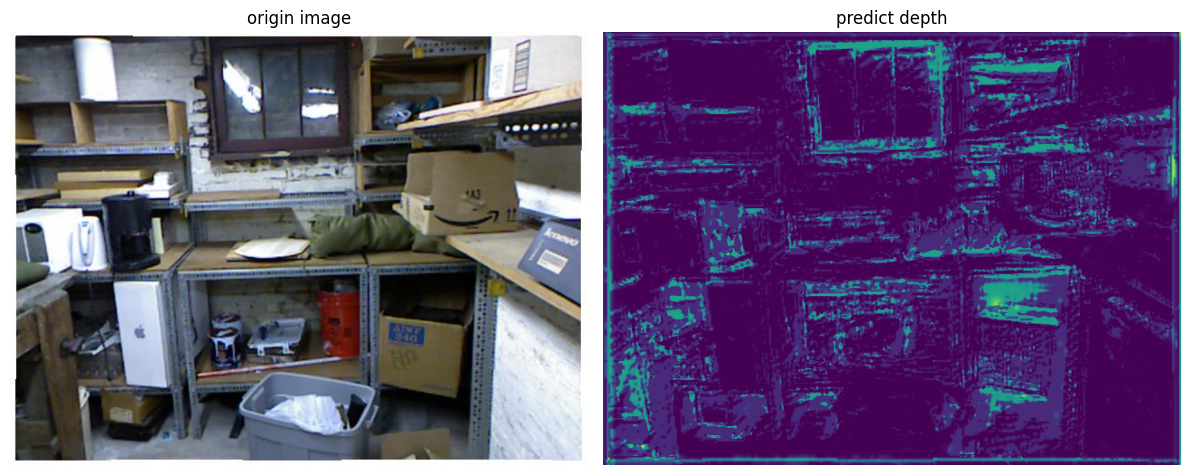

In [20]:
import mindspore as ms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_input(image_path, target_size=(480, 640)):
    # 1. 读取图像
    img = Image.open(image_path).convert("RGB")
    img_show = np.array(img, dtype=np.uint8)
    # 2. 尺寸缩放（如果输入尺寸非（480,640）则需要进行）
    # img = img.resize(target_size, Image.BILINEAR)
    # 3. 转为NumPy数组（HWC格式）
    img_np = np.array(img, dtype=np.float32) / 255.0  # 归一化到[0,1]
    # 4. 转为CHW格式
    img_np = img_np.transpose(2, 0, 1)  
    # 5. 归一化
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)  
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img_np = (img_np - mean) / std
    # 6. 转为MindSpore tensor
    img_tensor = ms.Tensor(img_np, dtype=ms.float32)
    # 7. 增加batch维度
    img_tensor = ms.ops.expand_dims(img_tensor, axis=0)  # 形状变为 (1, 3, H, W)
    return img_show,img_tensor

def load_model(model_class, ckpt_path):
    """
    输入：模型类、.ckpt文件路径
    输出：加载好权重的推理模型
    """
    # 1. 创建空的模型结构
    net = model_class()  
    # 2. 加载.ckpt文件中的权重参数
    param_dict = ms.load_checkpoint(ckpt_path) 
    # 3. 将权重注入模型（
    ms.load_param_into_net(net, param_dict)
    # 4. 切换为推理模式
    net.set_train(False)
    return net


def infer_depth(net, image_path, depth_scale=1000.0):  # depth_scale与训练时一致（1000.0表示mm→m）
    """
    输入：加载好的模型、图像路径、深度缩放因子
    输出：最终的深度图
    """
    # 1. 预处理输入图像
    img_show,input_tensor = preprocess_input(image_path)
    # 2. 执行推理
    pred_depth_tensor = ms.ops.stop_gradient(net(input_tensor))  
    # 3. 转换为numpy数组
    pred_depth = pred_depth_tensor.asnumpy()  
    # 4. 去除batch和通道维度，得到最终深度图（H, W）
    pred_depth = np.squeeze(pred_depth)  
    # 5. 还原深度值
    pred_depth = pred_depth * depth_scale  
    # 6. 过滤无效深度值
    pred_depth[pred_depth <= 0] = np.nan
    return img_show,pred_depth

if __name__ == "__main__":
    # 1. 配置路径（替换为加载图片的实际路径）
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ckpt_path = "./depth-estimation.ckpt"  
    test_image_path = "./basement_0001b_out_1.jpg"  
    # 2. 加载模型
    net = load_model(LDRN, ckpt_path)
    print("模型加载成功！")
    # 3. 执行推理
    inputimg,pred_depth = infer_depth(net, test_image_path, depth_scale=1)  # 
    # 4. 查看推理结果
    print(f"有效深度的均值：{np.nanmean(pred_depth):.2f} cm")
    
    # 可视化原始图像和深度图
    ax1.imshow(inputimg)
    ax1.set_title('origin image')
    ax1.axis('off')
    
    ax2.imshow(pred_depth, cmap='viridis')
    #plt.imshow(pred_depth,cmap='viridis')
    ax2.set_title('predict depth')
    ax2.axis('off')
    
    # plt.colorbar(label="Depth (mm)")
    # plt.title("Inferred Depth Map")
    # plt.axis("off")
    plt.tight_layout()
    plt.show()


训练代码

In [ ]:
# import mindspore as ms
# from mindspore import nn, ops, Model, save_checkpoint
# from mindspore.train.callback import Callback, LossMonitor, ModelCheckpoint, CheckpointConfig
# import os
# import time
# from PIL import Image


# class mydataset:
#     def __init__(self, img_root, depth_root):
#         self.img_root = img_root
#         self.depth_root = depth_root
        
        
#         self.img_list = self._filter_valid_files(img_root)
#         self.depth_list = self._filter_valid_files(depth_root)
        
        
#         assert len(self.img_list) == len(self.depth_list), \
#             f"RGB图像数量({len(self.img_list)})与深度图数量({len(self.depth_list)})不匹配！"

#     def _filter_valid_files(self, root_dir):
#         """过滤目录下的有效图像文件：排除目录、隐藏文件、非图像格式"""
       
#         valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
#         valid_files = []
        
#         for filename in os.listdir(root_dir):
#             # 1. 排除隐藏文件/目录
#             if filename.startswith('.'):
#                 continue
#             # 2. 排除目录
#             file_path = os.path.join(root_dir, filename)
#             if os.path.isdir(file_path):
#                 continue
#             # 3. 排除非图像格式文件
#             if not filename.lower().endswith(valid_extensions):
#                 continue
#             # 4. 保留有效文件
#             valid_files.append(file_path)
        
#         # 排序
#         valid_files.sort()
#         return valid_files

#     def __getitem__(self, idx):
#         # 直接使用预存的完整路径，无需再次拼接
#         img_path = self.img_list[idx]
#         depth_path = self.depth_list[idx]
#         #print(img_path)
#         #print(depth_path)
#         # 读取图像并处理（根据需要调整尺寸，确保输入网络的尺寸一致）
#         img = Image.open(img_path)  # 示例：统一缩放到224x224
#         depth = Image.open(depth_path)  # 深度图需与RGB图尺寸一致
        
#         # 注意：如果深度图是单通道，无需convert('RGB')，保持L模式即可
#         return img, depth

#     def __len__(self):
#         return len(self.img_list)



# class DepthLoss(nn.LossBase):
#     """极简深度损失：仅保留“有效区域L1损失”核心，无冗余计算"""
#     def __init__(self, reduction="mean"):
#         super(DepthLoss, self).__init__(reduction)
#         self.l1_loss = nn.L1Loss(reduction="none")  
#         self.cast = ops.Cast() 

#     def construct(self, predict, target):
        
#         assert predict.shape == target.shape, f"形状不匹配：predict{predict.shape} vs target{target.shape}"
        
#         # 1.掩码生成 
#         mask = self.cast(ops.gt(target, 0), ms.float32)
        
#         # 3. L1损失计算
#         l1_valid = self.l1_loss(predict, target) * mask  # 逐元素L1 + 掩码过滤
   
#         loss = l1_valid.sum() / (mask.sum() + 1e-6)  
        
#         return self.get_loss(loss)

# class TrainCallback(Callback):
#     """自定义训练回调，记录训练时间和每轮损失"""
#     def __init__(self, epoch_size):
#         self.epoch_size = epoch_size
#         self.epoch_time = 0
        
#     def on_epoch_begin(self, run_context):
#         self.epoch_time = time.time()
        
#     def on_epoch_end(self, run_context):
#         cb_params = run_context.original_args()
#         epoch = cb_params.cur_epoch_num
#         loss = cb_params.net_outputs.asnumpy()
#         time_cost = time.time() - self.epoch_time
        
#         print(f"Epoch [{epoch}/{self.epoch_size}], Loss: {loss:.4f}, Time: {time_cost:.2f}s")


# def train(net):
#     # 1. 数据集配置
#     img_root = '/home/ma-user/work/depth/data/img/rgbimg_less'
#     depth_root = '/home/ma-user/work/depth/data/depth/depthimg_less'
#     loader = mydataset(img_root, depth_root)  
#     dataset = ms.dataset.GeneratorDataset(source=loader, column_names=["data", "label"])
    
#     # 图像预处理
#     dataset = dataset.map(operations=[
#         ms.dataset.vision.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ms.dataset.vision.ToTensor(),
#     ], input_columns=['data'])
    
#     # 深度图预处理
#     dataset = dataset.map(operations=[
#         ms.dataset.vision.Rescale(1.0/100.0, 0),  # 深度值单位转换（从cm到m）
#         ms.dataset.vision.ToTensor(),  
#     ], input_columns=['label'])
    
#     dataset = dataset.batch(8)
#     dataset = dataset.shuffle(buffer_size=dataset.get_dataset_size())  
    
#     # 2. 网络模型定义
#     net = LDRN()
    
#     # 3. 损失函数和优化器
#     loss_fn = DepthLoss()
#     optimizer = nn.Adam(net.trainable_params(), learning_rate=1e-4, weight_decay=1e-5)
    
#     # 4. 训练配置
#     epochs = 100
#     ckpt_dir = "./ckpt"
#     os.makedirs(ckpt_dir, exist_ok=True)
    
#     # 配置模型保存参数
#     config_ckpt = CheckpointConfig(save_checkpoint_steps=dataset.get_dataset_size(),
#                                   keep_checkpoint_max=10,
#                                   save_checkpoint_epochs=10)
#     ckpt_callback = ModelCheckpoint(prefix="depth_estimation",
#                                    directory=ckpt_dir,
#                                    config=config_ckpt)
    
#     # 5. 构建模型
#     model = Model(net, loss_fn=loss_fn, optimizer=optimizer)
    
#     # 6. 开始训练
#     print("Starting training...")
#     callbacks = [
#         LossMonitor(per_print_times=dataset.get_dataset_size()),  
#         TrainCallback(epochs),  
#         ckpt_callback  
#     ]
    
#     model.train(epochs, dataset, callbacks=callbacks)
#     print("Training completed!")
    
#     # 7. 保存最终模型
#     final_ckpt_path = os.path.join(ckpt_dir, "final_model.ckpt")
#     save_checkpoint(net, final_ckpt_path)
#     print(f"Final model saved to {final_ckpt_path}")
# net = LDRN()
# train(net)


Starting training...
epoch: 1 step: 2, loss is 502.03485107421875
epoch: 2 step: 2, loss is 422.8581237792969
epoch: 3 step: 2, loss is 359.5219421386719
epoch: 4 step: 2, loss is 325.8969421386719
epoch: 5 step: 2, loss is 273.9981384277344
epoch: 6 step: 2, loss is 258.3226318359375
epoch: 7 step: 2, loss is 238.43223571777344
epoch: 8 step: 2, loss is 215.8788299560547
epoch: 9 step: 2, loss is 191.37229919433594
epoch: 10 step: 2, loss is 179.1562042236328
epoch: 11 step: 2, loss is 144.93222045898438
epoch: 12 step: 2, loss is 154.72860717773438
epoch: 13 step: 2, loss is 154.5168914794922
epoch: 14 step: 2, loss is 129.01983642578125
epoch: 15 step: 2, loss is 105.12445068359375
epoch: 16 step: 2, loss is 90.90706634521484
epoch: 17 step: 2, loss is 83.12254333496094
epoch: 18 step: 2, loss is 72.90448760986328
epoch: 19 step: 2, loss is 74.84418487548828
epoch: 20 step: 2, loss is 67.92411041259766
epoch: 21 step: 2, loss is 65.66815185546875
epoch: 22 step: 2, loss is 61.901073